In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport compute_comethylation, somatic_mut_clock
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, somatic_mut_clock

In [6]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
from scipy.stats import spearmanr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV

%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")

# Get data

In [8]:
out_dir = "./output_dirs/output_120522"
dependency_f_dir = "./dependency_files"
data_dir = "./data"
corr_dir = '/cellar/users/zkoch/methylation_and_mutation/dependency_files/chr_dset_corrs'
methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/dropped3SD_qnormed_methylation'

In [9]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, dataset_names_list = get_data.main(
    illum_cpg_locs_fn = os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"),
    out_dir = out_dir,
    methyl_dir = methylation_dir,
    mut_fn = os.path.join(data_dir, "PANCAN_mut.tsv.gz"),
    meta_fn = os.path.join(data_dir, "PANCAN_meta.tsv"))

Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [10]:
# read in other already computed files
# from running analysis.main() 
mut_in_measured_cpg_w_methyl_age_df = pd.read_parquet(os.path.join(dependency_f_dir, "mut_in_measured_cpg_w_methyl_age_df_5year.parquet"))
# add ages to all_methyl_df_t
all_mut_w_age_df, all_methyl_age_df_t = utils.add_ages_to_mut_and_methyl(all_mut_df, all_meta_df, all_methyl_df_t)


# Somatic mutation clock

In [ ]:
# For each CpG
# STEP 1: Filter to mutated sites on same chr
# STEP 2: predictor_sites:
#   most correlated
#   the site itself
#   any site from databases that affect the CpG
#   all sites within 2kb window
#   all sites with significant association 
# STEP 3: train linear model on the mutation status of predictor_sites
#   elasticNet bc greedily including many features 
# TODO: maybe try other models

In [ ]:
# Evaluate how well smeQTLs predict methylation status
# STEP 1: 5-fold CV with elasticNet (nested 5-fold) on each CpG
# STEP 2: record the cpg being predicted, r2's, MAEs, and selected feature names
# STEP 3: save this as a df 

In [ ]:
# TODO:
# Speed the predictor training way up
    # done-ish

# Second stage model: takes in predicted methylation and builds a standard epi clock
# STEP 1: For each sample, get the predicted methylation status for each CpG
# STEP 2: Feature selection (mutual information)
# STEP 3: ElasticNet
# OPTIONAL: 
    # add in a couple other features: mutation burden, C>T mutation burden
    # have a separate model for each tissue type

#### Performance

In [7]:
clock_perf_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_122622/all_cpg_predictions_df.parquet")

In [8]:
clock_perf_df.set_index("cpg_id", inplace=True)

In [9]:
clock_perf_df['mean_mae'] = clock_perf_df['mae'].apply(lambda x: np.mean(x))
clock_perf_df['mean_r2'] = clock_perf_df['r2'].apply(lambda x: np.mean(x))
clock_perf_df['base_mean_mae'] = clock_perf_df['base_mae'].apply(lambda x: np.mean(x))
clock_perf_df['base_mean_r2'] = clock_perf_df['base_r2'].apply(lambda x: np.mean(x))
clock_perf_df['num_features'] = clock_perf_df['feature_names'].apply(lambda x: len(x[0]))
clock_perf_df['base_num_features'] = clock_perf_df['base_feature_names'].apply(lambda x: len(x[0]))

Text(0.5, 0, 'Gender and tissue type MAE')

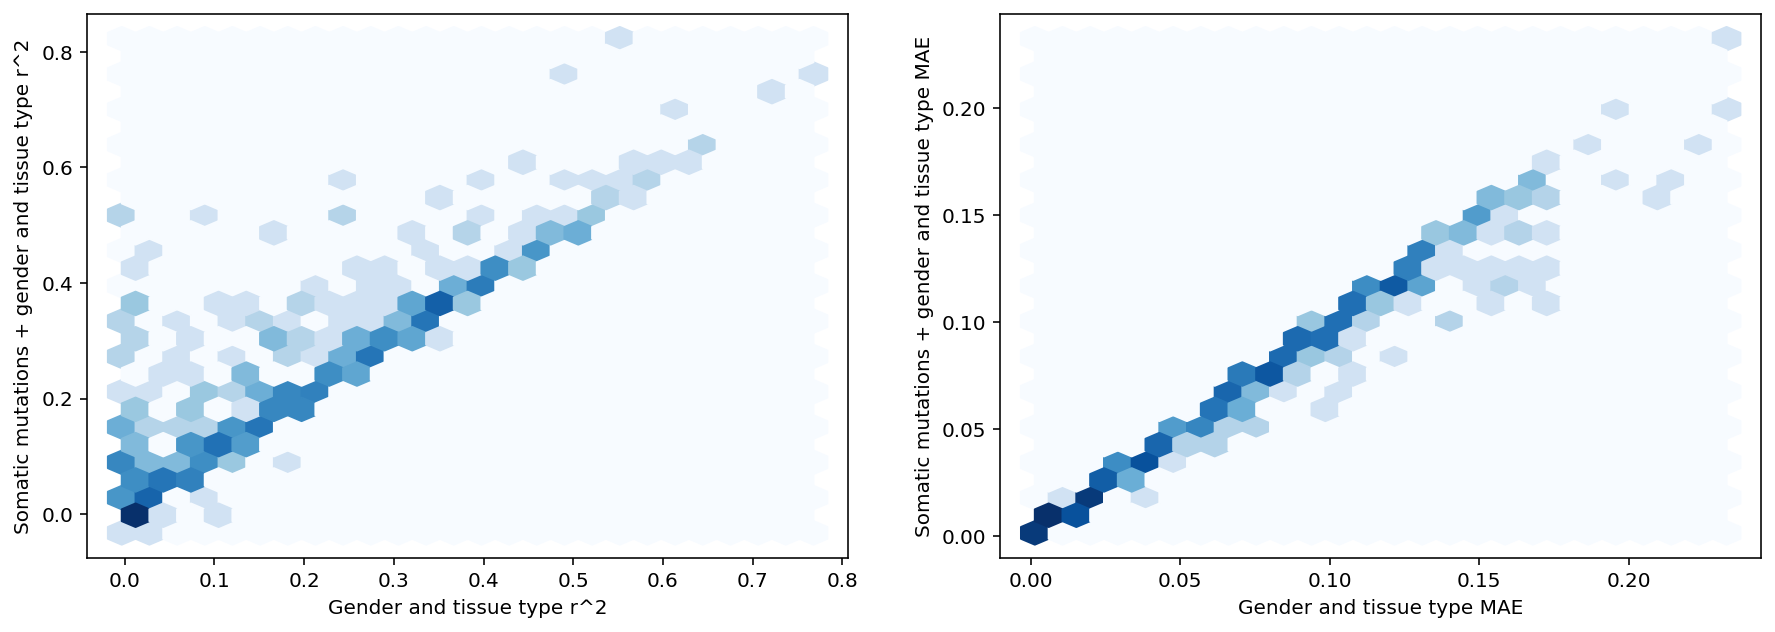

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hexbin(clock_perf_df['base_mean_r2'], clock_perf_df['mean_r2'], gridsize=25, cmap='Blues', bins='log')
axes[0].set_ylabel("Somatic mutations + gender and tissue type r^2")
axes[0].set_xlabel("Gender and tissue type r^2")

axes[1].hexbin(clock_perf_df['base_mean_mae'], clock_perf_df['mean_mae'], gridsize=25, cmap='Blues', bins='log')
axes[1].set_ylabel("Somatic mutations + gender and tissue type MAE")
axes[1].set_xlabel("Gender and tissue type MAE")

/tmp/ipykernel_265258/498103967.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  clock_perf_df[['mean_mae', 'base_mean_mae','mean_r2', 'base_mean_r2', 'num_features',   'base_num_features']].hist(ax = axes)


array([[<AxesSubplot:title={'center':'mean_mae'}>,
        <AxesSubplot:title={'center':'base_mean_mae'}>],
       [<AxesSubplot:title={'center':'mean_r2'}>,
        <AxesSubplot:title={'center':'base_mean_r2'}>],
       [<AxesSubplot:title={'center':'num_features'}>,
        <AxesSubplot:title={'center':'base_num_features'}>]], dtype=object)

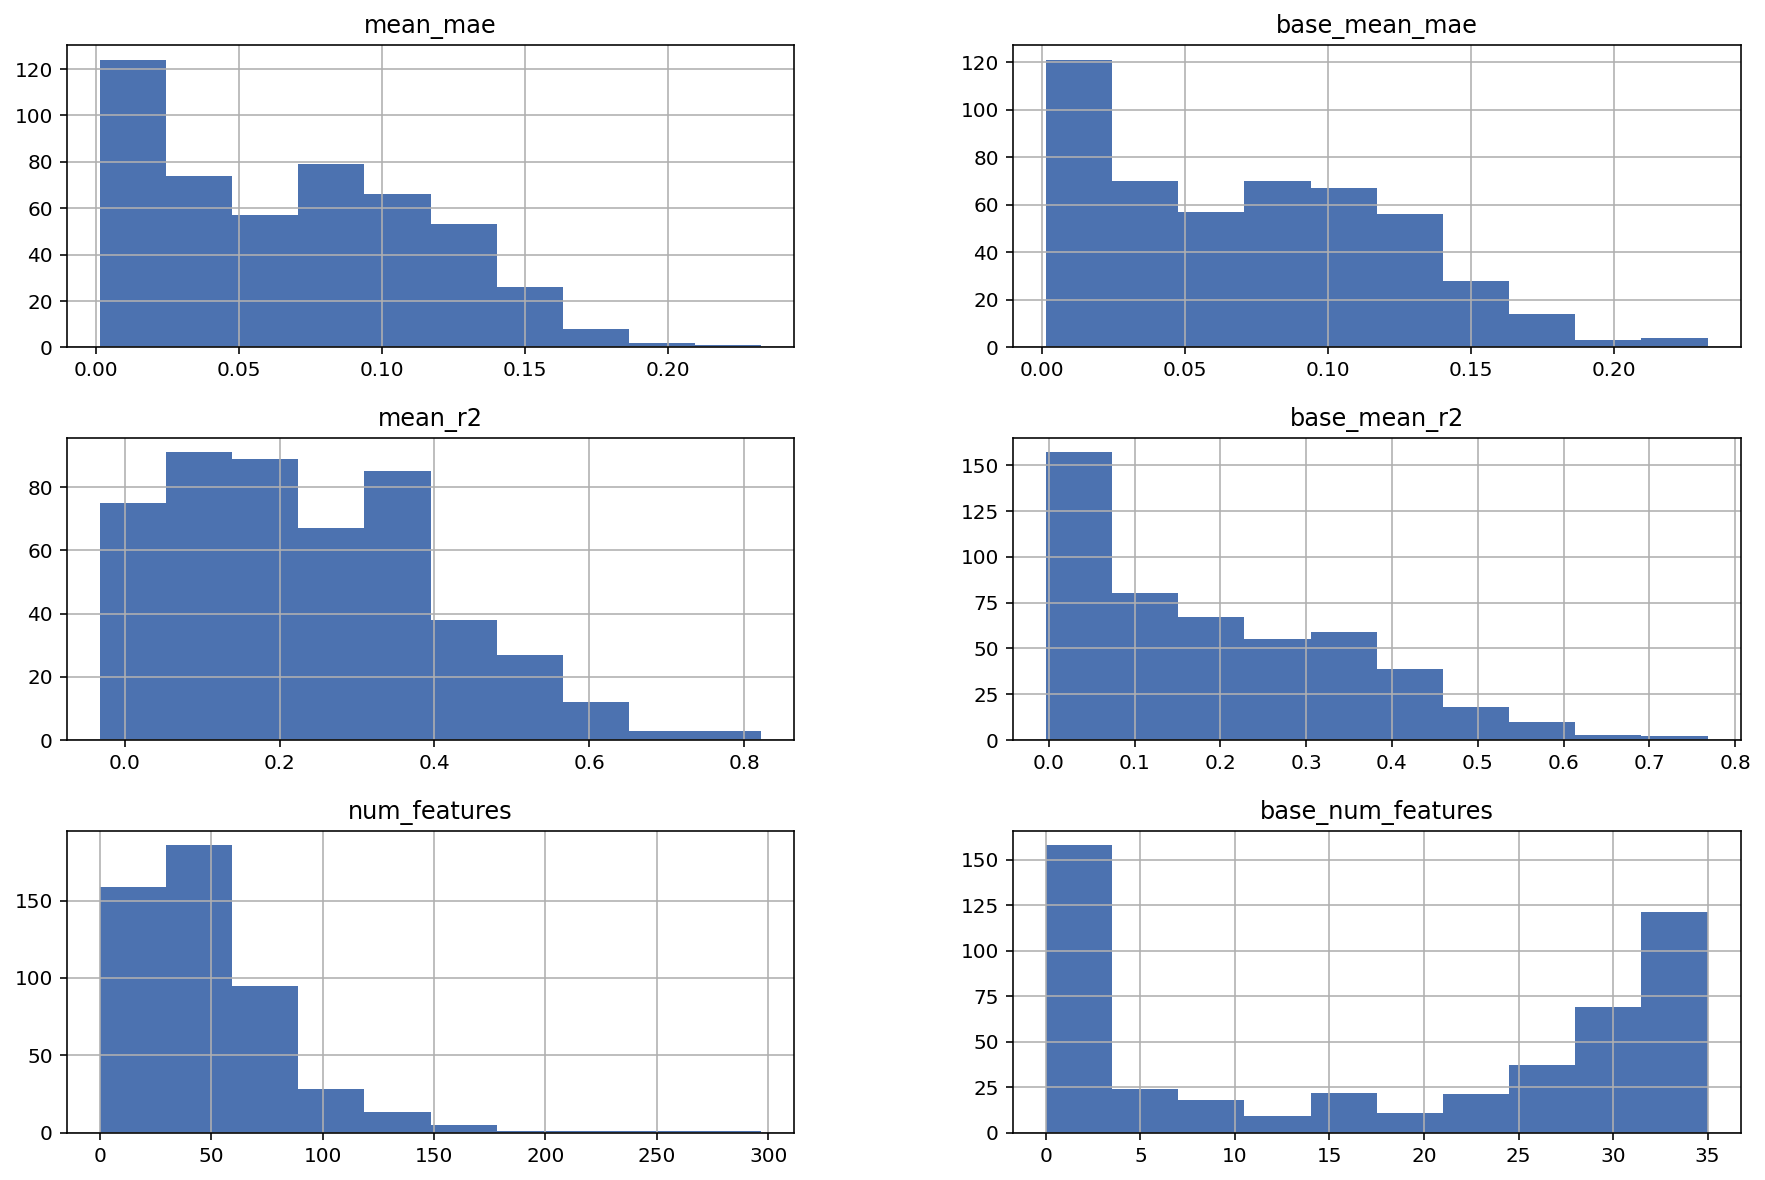

In [10]:
fig, axes = plt.subplots(figsize=(15, 10))
clock_perf_df[['mean_mae', 'base_mean_mae','mean_r2', 'base_mean_r2', 'num_features',   'base_num_features']].hist(ax = axes)

#### Define train and test

In [ ]:
# how to define the 80% training and 20% testing set?
    # randomly choose 20% of samples as testing, balancing dataset and age
    # use the rest for training
    # propogate this through having a file called train_samples.tsv and test_samples.tsv

In [134]:
from sklearn.model_selection import train_test_split

In [141]:
# balance dataset between training and testing
X_train, X_test = train_test_split(all_methyl_age_df_t, random_state=0, test_size=0.2, train_size=0.8, stratify=all_methyl_age_df_t['dataset'])

<AxesSubplot:>

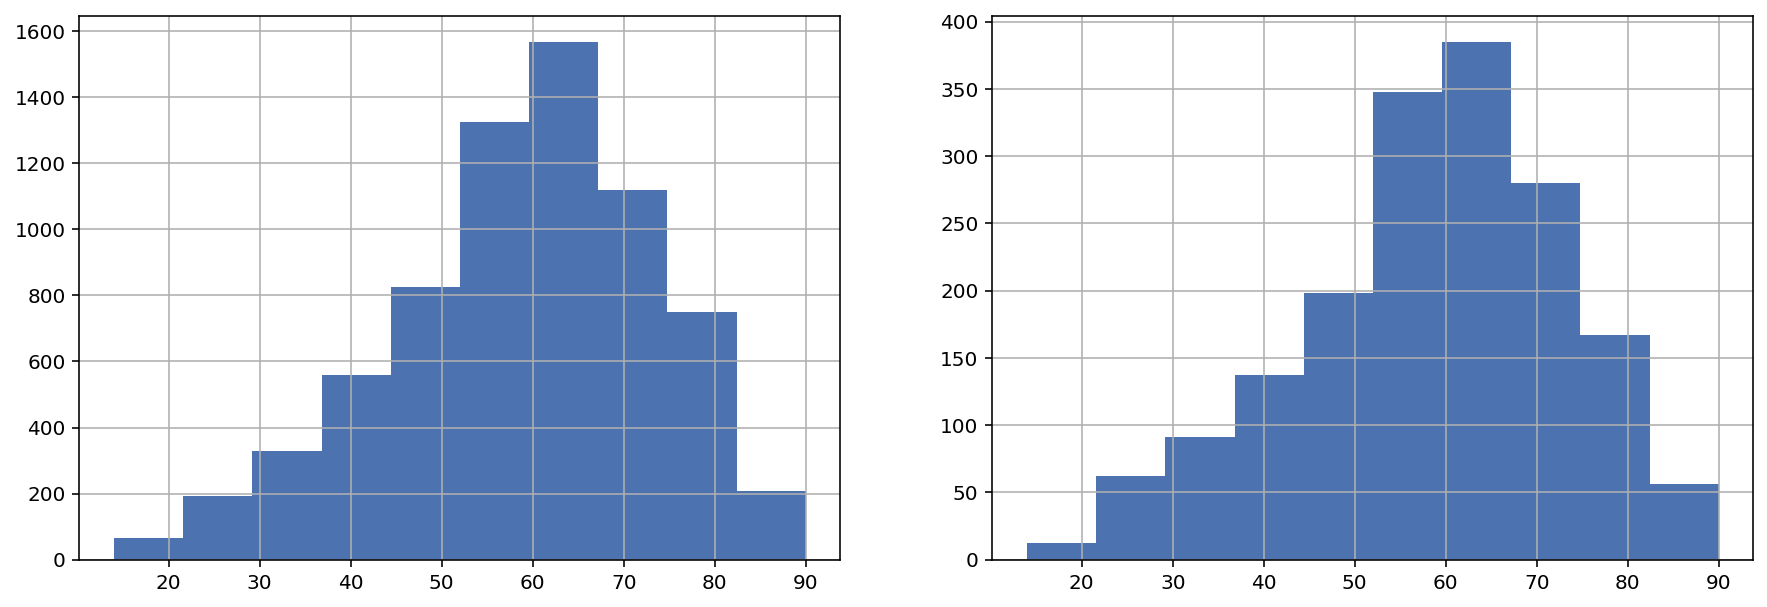

In [150]:
# this also results in a fairly balanced age distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
X_train['age_at_index'].hist(ax=axes[0])
X_test['age_at_index'].hist(ax = axes[1])


#### Train predictors

In [13]:
mut_clock = somatic_mut_clock.mutationClock(
    all_mut_w_age_df, 
    illumina_cpg_locs_df, 
    all_methyl_age_df_t,
    output_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423"
    )

In [155]:
mut_clock.train_all_predictors(num_correl_sites = 1000, max_meqtl_sites = 1000, nearby_window_size = 5000, cpg_ids = ["cg18612167"], samples = all_methyl_age_df_t.index[:1000])

0


In [15]:
predictor_sites = mut_clock.get_predictor_sites(
    cpg_id = "cg18612167", train_samples = all_methyl_age_df_t.index[:1000], num_correl_sites = 1000,
    max_meqtl_sites = 1000, nearby_window_size = 5000
    )

In [159]:
df = mut_clock.evaluate_predictor(cpg_id="cg18612167", samples = all_methyl_age_df_t.index[:1000], predictor_sites=predictor_sites)

In [20]:
mut_clock.illumina_cpg_locs_df

,#id,chr,start,Strand
11648,cg00000165,1,91194674,R
11649,cg00000363,1,230560793,F
11650,cg00000957,1,5937253,F
11651,cg00001349,1,166958439,R
11653,cg00001446,1,43831041,R
...,...,...,...,...
485454,cg27653384,22,22293118,F
485455,cg27656573,22,30127118,R
485457,cg27657537,22,20863762,F
485460,cg27662611,22,38598981,F


In [17]:
X, y = mut_clock._create_training_mat("cg18612167", predictor_sites, samples = all_methyl_age_df_t.index[:1000])

In [18]:
model2 = ElasticNetCV(cv=5, random_state=0, max_iter=5000, selection = 'random', n_jobs=5)
model2.fit(X, y)

ElasticNetCV(cv=5, max_iter=5000, n_jobs=5, random_state=0, selection='random')

In [19]:
model2.feature_names_in_

array(['10:100177438', '10:106959851', '10:5488816', '10:65225319',
       '10:70967645', '10:75258311', '10:75585063', '10:76735894',
       '10:94393481', '10:95791282', '11:111796690', '11:18266895',
       '11:3832618', '11:4843090', '11:55541501', '11:57971564',
       '11:57982680', '11:59481178', '11:60183673', '11:61249901',
       '11:64519109', '11:65822729', '11:67059647', '11:71249735',
       '11:71277140', '11:71277173', '11:71277197', '11:71277309',
       '11:71277311', '11:71293823', '11:85406273', '12:109526072',
       '12:15073916', '12:21971159', '12:52761062', '12:54798224',
       '12:56234912', '12:57485001', '12:6153464', '12:69968409',
       '12:70004511', '12:98927155', '13:108862231', '13:113897336',
       '14:106236243', '14:53525268', '14:59970581', '14:72936741',
       '14:74402681', '14:88789140', '14:93273203', '14:95081321',
       '14:96944864', '15:41029892', '15:42092085', '15:45437191',
       '15:51828879', '15:65685759', '15:67878265', '15:695

In [226]:
from sklearn.linear_model import ElasticNet

In [227]:
model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=0, max_iter=5000, selection = 'random')
model.fit(X, y)

ElasticNet(alpha=0.1, max_iter=5000, random_state=0, selection='random')

In [11]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

df = pd.DataFrame({"cities": ["Paris", "Tokyo", "Paris", "Auckland"],
                   "eyes": ["Blue", "Brown", "Green", "Blue"]},
                  index=["Alice", "Bunji", "Cécile", "Dave"])
encoder = OneHotEncoder()
encoder.fit(df)
assert list(encoder.feature_names_in_) == ["cities", "eyes"]

In [229]:
model._feature_names_in_

AttributeError: 'ElasticNet' object has no attribute '_feature_names_in_'

In [212]:
X

,10:100177438,10:106959851,10:5488816,10:65225319,10:70967645,10:75258311,10:75585063,10:76735894,10:94393481,10:95791282,...,dataset_READ,dataset_SARC,dataset_SKCM,dataset_STAD,dataset_TGCT,dataset_THCA,dataset_THYM,dataset_UCEC,dataset_UCS,dataset_UVM
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5J1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
TCGA-OR-A5J3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
TCGA-OR-A5J4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
TCGA-OR-A5J5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
TCGA-OR-A5J6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-D8-A27T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
TCGA-D8-A27V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
TCGA-D8-A27W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [218]:
model2.coef_[model2.coef_ != 0]

array([-0.02506759,  0.00217649,  0.07710786, -0.04039096])

In [ ]:
# 5 workers 46s
# 10 workers 43s
# 20 workers 47s

In [43]:
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV(cv=5, random_state=0, max_iter=5000, selection = 'random', verbose=1, n_jobs=10)
model.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


ElasticNetCV(cv=5, max_iter=5000, random_state=0, selection='random', verbose=1)

In [ ]:
predictor_sites = mut_clock.get_predictor_sites(
    cpg_id = 'cg00000363', num_correl_sites = 1000,
    max_meqtl_sites = 1000, nearby_window_size = 2000
    )

In [ ]:
cpg_df = mut_clock.train_one_predictor(cpg_id = 'cg00000363', predictor_sites = predictor_sites)

#### Apply predictions

In [ ]:
df =  mut_clock.predict_cpg(cpg_id = 'cg00002406', test_samples = all_methyl_age_df_t.index.to_list(), model_fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/cg00002406.pkl")

In [33]:
all_pred_methyl_df = mut_clock.predict_all_cpgs(cpg_ids = ["cg00000292", "cg00000924", "cg00001249"], test_samples=all_methyl_age_df_t.index.to_list(), model_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423")

array([[<AxesSubplot:title={'center':'cg00000292'}>,
        <AxesSubplot:title={'center':'cg00000924'}>],
       [<AxesSubplot:title={'center':'cg00001249'}>, <AxesSubplot:>]],
      dtype=object)

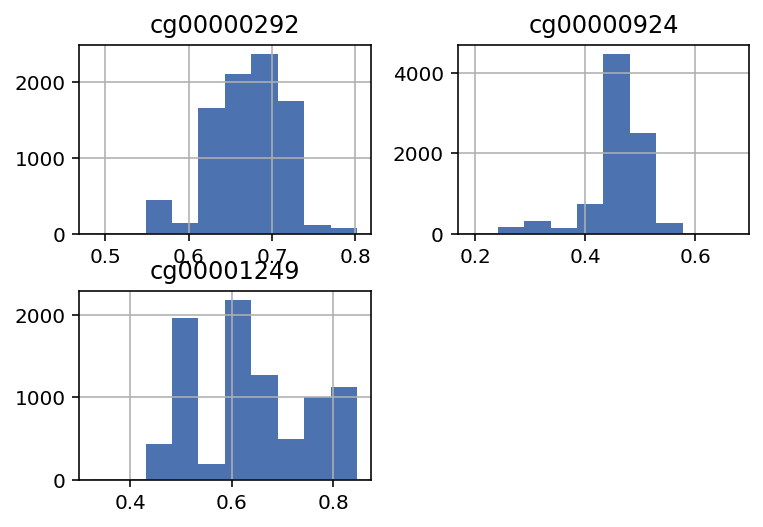

In [35]:
all_pred_methyl_df.hist()